In [ ]:
import nilearn
from nilearn import datasets, plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import MultiNiftiLabelsMasker
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import scipy
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics.cluster import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from collections import deque, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import torch

In [21]:
# load gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [150]:
home_base_dir = '/Users/aj/dmello_lab/fmri_connectivity_trees' # directory where repository lives at home computer
lab_base_dir = '/Users/ajjain/Downloads/Code/fmri_connectivity_trees' # directory where repository lives at lab computer

# set base directory depending on where the code is being run
base_dir = home_base_dir if os.path.exists(home_base_dir) else lab_base_dir

# get msdl and whole brain atlases and coords
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

# get schaefer
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
schaefer_coords = plotting.find_parcellation_cut_coords(labels_img=schaefer.maps)

# concatenate timeseries to get a single timeseries for each subject
def get_timeseries(ids, subject, cort_shape_path, cort_pooled_path, story_timeseries={}):
    pooled_timeseries = []
    for id in ids:

        # load the shape and pooled timeseries
        shape = np.loadtxt(f'{cort_shape_path}/{id}.csv', delimiter=',').astype(int)
        pooled = np.loadtxt(f'{cort_pooled_path}/{id}.csv', delimiter=',').reshape(shape)

        # append to story timeseries
        story_timeseries[subject][id] = pooled

        # concatenate the timeseries
        pooled_timeseries.append(pooled)

    return pooled_timeseries, story_timeseries

# path for shapes and pooled timeseries
subjects = [
            'L010', 
            'L012'
            ]
sessions = ['01', '02']

# get stories
stories = {}
    
ids_path_1 = f"{base_dir}/datasets/listen/listen_file_ids_ses-01.txt"
with open(ids_path_1, 'r') as f:
        file_ids = f.readlines()
        file_ids = [x.strip() for x in file_ids]
        stories['01'] = file_ids

ids_path_2 = f"{base_dir}/datasets/listen/listen_file_ids_ses-02.txt"
with open(ids_path_2, 'r') as f:
        file_ids = f.readlines()
        file_ids = [x.strip() for x in file_ids]
        stories['02'] = file_ids

set_stories = False
if set_stories:
    stories['01'] = ['alternateithicatom']
    stories['02'] = ['undertheinfluence']

atlas = 'Schaefer'

pooled_timeseries = {}
story_timeseries = {}
for subject in subjects:
    cort_shape_path = f'{base_dir}/code/functional_connectivity/listen/output/roi_time_series/{subject}/01/{atlas}/stories/shape/'
    cort_pooled_path = f'{base_dir}/code/functional_connectivity/listen/output/roi_time_series/{subject}/01/{atlas}/stories/pooled/'
    story_timeseries[subject] = {}
    pooled_timeseries[subject], story_timeseries = get_timeseries(stories['01'], subject, cort_shape_path, cort_pooled_path, story_timeseries=story_timeseries)
    cort_shape_path = f'{base_dir}/code/functional_connectivity/listen/output/roi_time_series/{subject}/02/{atlas}/stories/shape/'
    cort_pooled_path = f'{base_dir}/code/functional_connectivity/listen/output/roi_time_series/{subject}/02/{atlas}/stories/pooled/'
    pooled, story_timeseries = get_timeseries(stories['02'], subject, cort_shape_path, cort_pooled_path, story_timeseries=story_timeseries)
    pooled_timeseries[subject] = pooled_timeseries[subject] + pooled

[get_dataset_dir] Dataset found in /Users/aj/nilearn_data/msdl_atlas

[get_dataset_dir] Dataset found in /Users/aj/nilearn_data/schaefer_2018

In [3]:
sub1_concat = np.concatenate(pooled_timeseries['L010'], axis=0).T
sub2_concat = np.concatenate(pooled_timeseries['L012'], axis=0).T

In [4]:
def get_covariance(timeseries):
    """
    Get the covariance matrix of the concatenated timeseries.
    """
    # get the covariance matrix
    cov = np.cov(timeseries)

    for i in range(len(cov)):
        for j in range(len(cov)):
            if i == j:
                cov[i][j] = 0

    return cov

# get covariance matrices
sub1_cov = get_covariance(sub1_concat) # sub1 covariance matrix
sub2_cov = get_covariance(sub2_concat) # sub2 covariance matrix

In [5]:
def plot_connectome(cov_matrix, coords, title='connectome', edge_threshold="0%", edge_vmin=0, edge_vmax=1):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """
    # Plotting the connectome
    plotting.plot_connectome(
        cov_matrix,
        coords,
        title=title,
        edge_vmin = edge_vmin,
        edge_vmax = edge_vmax,
        edge_cmap='cold_hot',
        edge_threshold=edge_threshold,  # Only plot edges above the 90th percentile
        colorbar=True,
        node_size=10,
    )
    plt.show()

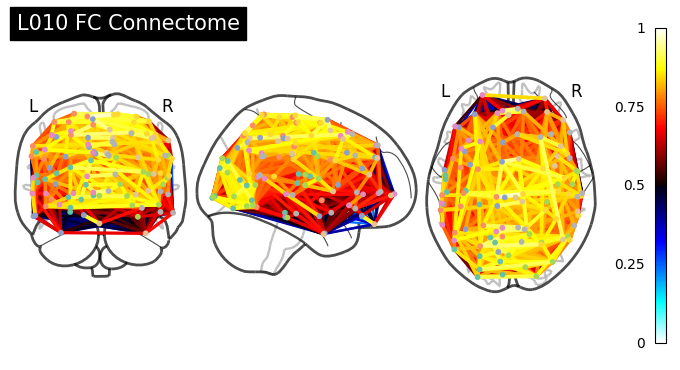

In [7]:
plot_connectome(sub1_cov, schaefer_coords, title='L010 FC Connectome', edge_threshold="0%")

In [9]:
atlas_subdir = 'schaefer_100'

# save matrices to csv
sub1_cov_df = pd.DataFrame(sub1_cov)
cov_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/covariance/L010/{atlas_subdir}/all_stories.csv'
if not os.path.exists(cov_path_1):
    os.makedirs(os.path.dirname(cov_path_1), exist_ok=True)
sub1_cov_df.to_csv(cov_path_1, index=False)

cov_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/covariance/L012/{atlas_subdir}/all_stories.csv'
if not os.path.exists(cov_path_2):
    os.makedirs(os.path.dirname(cov_path_2), exist_ok=True)
sub2_cov_df = pd.DataFrame(sub2_cov)
sub2_cov_df.to_csv(cov_path_2, index=False)

In [10]:
sub1_concat.shape

(100, 3834)

In [11]:
# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

# create masker using MultiNiftiLabelsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# computation
masker = MultiNiftiLabelsMasker(
    labels_img=schaefer.maps,  # Both hemispheres
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    n_jobs=2,
)


# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform([sub1_concat.T])

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
sub1_corr = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=schaefer.maps)

In [8]:
# atlas_subdir = 'schaefer_100'
# pd.DataFrame(sub1_corr).to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/connectome_corr/msc01/{atlas_subdir}/motor.csv', index=False)

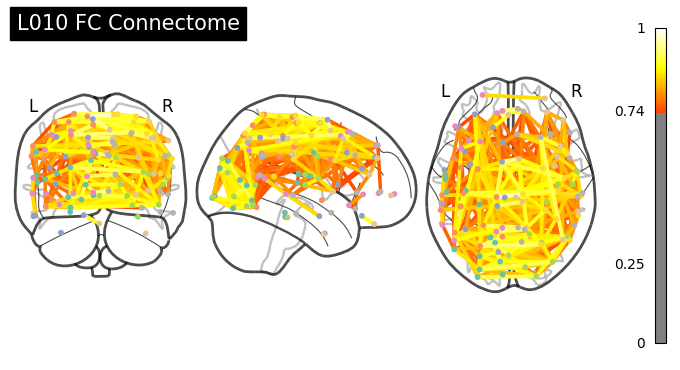

In [13]:
# also color code these connections based on motor, visual, etc.
plot_connectome(sub1_corr, schaefer_coords, title='L010 FC Connectome', edge_threshold="90%")

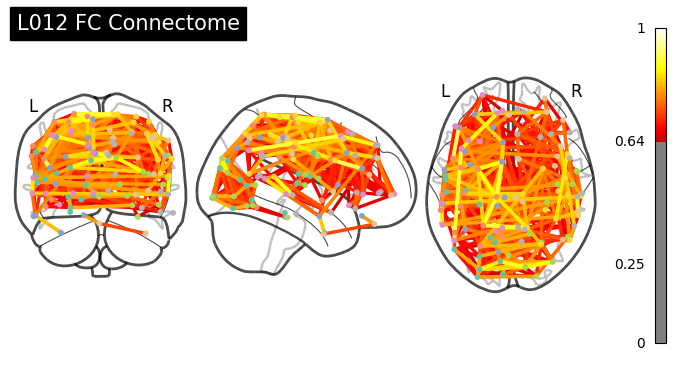

In [15]:
plot_connectome(sub2_cov, schaefer_coords, title='L012 FC Connectome', edge_threshold="90%")

In [25]:
def mutual_information_continuous(x, y, bins=10):
    """
    Estimate mutual information between two continuous variables by discretizing them.

    Parameters:
    x (array-like): First continuous variable.
    y (array-like): Second continuous variable.
    bins (int): Number of bins to use for discretization.

    Returns:
    float: Estimated mutual information.
    """
    # Convert to pandas Series
    x = pd.Series(x)
    y = pd.Series(y)

    # Discretize the continuous values
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)

    # Compute contingency table
    contingency_table = pd.crosstab(x_binned, y_binned)

    # Compute mutual information
    mi = mutual_info_score(None, None, contingency=contingency_table.values)

    return mi

def get_mutual_info(timeseries, bins=100):

    mutual_info_matrix = np.zeros((timeseries.shape[1], timeseries.shape[1]))

    # get mutual information
    for region in range(timeseries.shape[1]):
        for region2 in range(timeseries.shape[1]):
            if region != region2:
                mutual_info = mutual_information_continuous(timeseries[:, region], timeseries[:, region2], bins=bins)
                mutual_info_matrix[region, region2] = mutual_info
    
    return mutual_info_matrix

In [26]:
# try all timepoints, 10 bins
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_10bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(sub1_concat.T, bins=10)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_10bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(sub2_concat.T, bins=10)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

In [81]:
# try all timepoints, 100 bins
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_100bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(sub1_concat.T, bins=100)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_100bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(sub2_concat.T, bins=100)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

In [82]:
# try all timepoints, 1000 bins
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_1000bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(sub1_concat.T, bins=1000)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_1000bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(sub2_concat.T, bins=1000)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

In [83]:
# try all timepoints, 10000 bins
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_10000bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(sub1_concat.T, bins=10000)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_10000bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(sub2_concat.T, bins=10000)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

In [155]:
# try for one story
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/alternateithicatom_10bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(story_timeseries['L010']['alternateithicatom'], bins=10)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/alternateithicatom_10bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(story_timeseries['L012']['alternateithicatom'], bins=10)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

# 100 bins
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/alternateithicatom_100bins.csv'
if not os.path.exists(mi_path_1):
    os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
sub1_mutual_info = get_mutual_info(story_timeseries['L010']['alternateithicatom'], bins=100)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(mi_path_1, index=False)

mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/alternateithicatom_100bins.csv'
if not os.path.exists(mi_path_2):
    os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
sub2_mutual_info = get_mutual_info(story_timeseries['L012']['alternateithicatom'], bins=100)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(mi_path_2, index=False)

In [183]:
# try for all stories

for story in stories['02']:
    session = '02'
    if session == '02' and story == 'wheretheressmoke': 
        story_name = 'wheretheressmoke_2'
    else: 
        story_name = story
    mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/{story_name}_10bins.csv'
    if not os.path.exists(mi_path_1):
        os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
    sub1_mutual_info = get_mutual_info(story_timeseries['L010'][story], bins=10)
    sub1_mi_df = pd.DataFrame(sub1_mutual_info)
    sub1_mi_df.to_csv(mi_path_1, index=False)

    mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/{story_name}_10bins.csv'
    if not os.path.exists(mi_path_2):
        os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
    sub2_mutual_info = get_mutual_info(story_timeseries['L012'][story], bins=10)
    sub2_mi_df = pd.DataFrame(sub2_mutual_info)
    sub2_mi_df.to_csv(mi_path_2, index=False)

    # # 100 bins
    # mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}{story}_100bins.csv'
    # if not os.path.exists(mi_path_1):
    #     os.makedirs(os.path.dirname(mi_path_1), exist_ok=True)
    # sub1_mutual_info = get_mutual_info(story_timeseries['L010'][story], bins=100)
    # sub1_mi_df = pd.DataFrame(sub1_mutual_info)
    # sub1_mi_df.to_csv(mi_path_1, index=False)

    # mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/{story}_100bins.csv'
    # if not os.path.exists(mi_path_2):
    #     os.makedirs(os.path.dirname(mi_path_2), exist_ok=True)
    # sub2_mutual_info = get_mutual_info(story_timeseries['L012'][story], bins=100)
    # sub2_mi_df = pd.DataFrame(sub2_mutual_info)
    # sub2_mi_df.to_csv(mi_path_2, index=False)

In [170]:
# load the saved matrices
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_100bins.csv'
mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_100bins.csv'
sub1_mutual_info = pd.read_csv(mi_path_1).to_numpy()
sub2_mutual_info = pd.read_csv(mi_path_2).to_numpy()

mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/alternateithicatom_10bins.csv'
mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/alternateithicatom_10bins.csv'
sub1_mutual_info_ait = pd.read_csv(mi_path_1).to_numpy()
sub2_mutual_info_ait = pd.read_csv(mi_path_2).to_numpy()

mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/alternateithicatom_100bins.csv'
mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/alternateithicatom_100bins.csv'
sub1_mutual_info_ait_100 = pd.read_csv(mi_path_1).to_numpy()
sub2_mutual_info_ait_100 = pd.read_csv(mi_path_2).to_numpy()

mutual_info_matrices = {}
for story in stories['01']:
    mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/{story}_10bins.csv'
    mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/{story}_10bins.csv'
    mutual_info_matrices[story] = {
        'L010': pd.read_csv(mi_path_1).to_numpy(),
        'L012': pd.read_csv(mi_path_2).to_numpy()
    }

In [184]:
for story in stories['02']:
    session = '02'
    if session == '02' and story == 'wheretheressmoke': 
        story_name = 'wheretheressmoke_2'
    else: 
        story_name = story
    mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/{story_name}_10bins.csv'
    mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/{story_name}_10bins.csv'
    mutual_info_matrices[story_name] = {
        'L010': pd.read_csv(mi_path_1).to_numpy(),
        'L012': pd.read_csv(mi_path_2).to_numpy()
    }

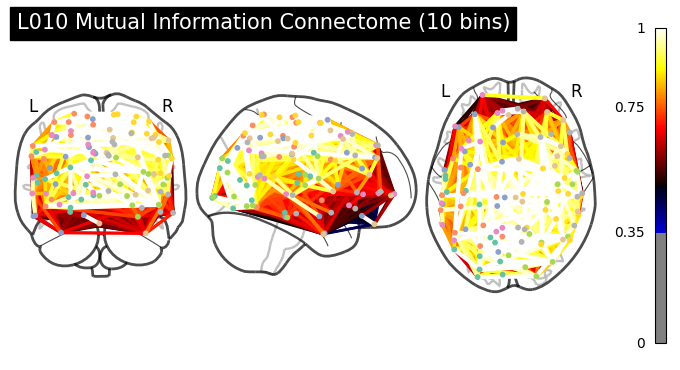

In [85]:
plot_connectome(sub1_mutual_info, schaefer_coords, title='L010 Mutual Information Connectome (10 bins)', edge_vmin=0, edge_threshold="0%")

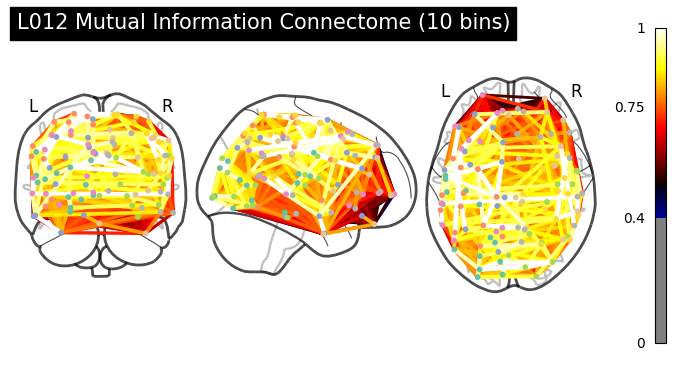

In [86]:
plot_connectome(sub2_mutual_info, schaefer_coords, title='L012 Mutual Information Connectome (10 bins)', edge_vmin=0, edge_threshold="0%")

In [31]:
# Construct the Chow-Liu tree from continuous data using mutual information.
def get_chow_liu_tree(timeseries, mi_matrix=None, bins=1000):
    
    # Compute the mutual information matrix
    if mi_matrix is None:
        mi_matrix = get_mutual_info(timeseries, bins=bins)

    # Set the diagonal to zero (self-information)
    np.fill_diagonal(mi_matrix, 0)

    # We use the negative MI because scipy's minimum_spanning_tree computes *minimum* tree.
    mst = minimum_spanning_tree(-mi_matrix).toarray()

    # Make MST undirected and remove negative sign
    mst = -mst + (-mst).T

    # Create NetworkX graph for visualization or further use
    G = nx.Graph()
    n = mi_matrix.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            if mst[i, j] != 0:
                G.add_edge(i, j, weight=mi_matrix[i, j])
    
    return G, mst

In [87]:
G_sub1, mst_sub1 = get_chow_liu_tree(sub1_concat, mi_matrix=sub1_mutual_info)
G_sub2, mst_sub2 = get_chow_liu_tree(sub2_concat, mi_matrix=sub2_mutual_info)
G_sub1_corr, mst_sub1_corr = get_chow_liu_tree(sub1_concat, mi_matrix=sub1_cov)
G_sub2_corr, mst_sub2_corr = get_chow_liu_tree(sub2_concat, mi_matrix=sub2_cov)

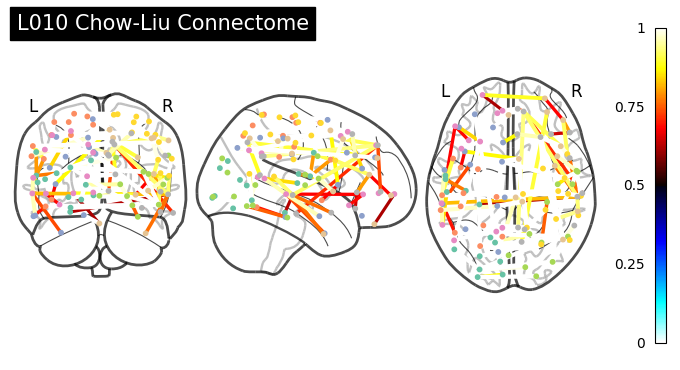

In [88]:
# identify clusters through color coding
plot_connectome(mst_sub1, schaefer_coords, title='L010 Chow-Liu Connectome', edge_threshold="0%")

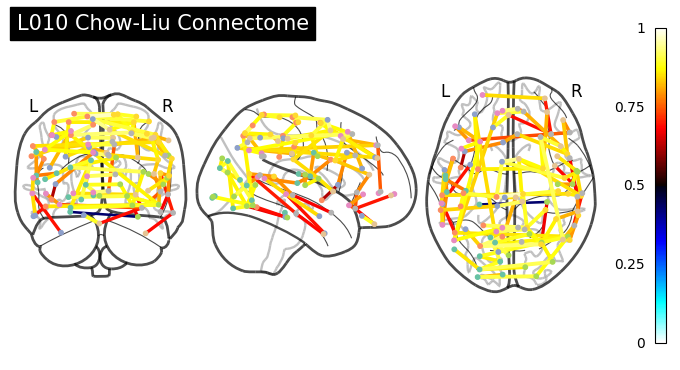

In [89]:
plot_connectome(mst_sub1_corr, schaefer_coords, title='L010 Chow-Liu Connectome', edge_threshold="0%")

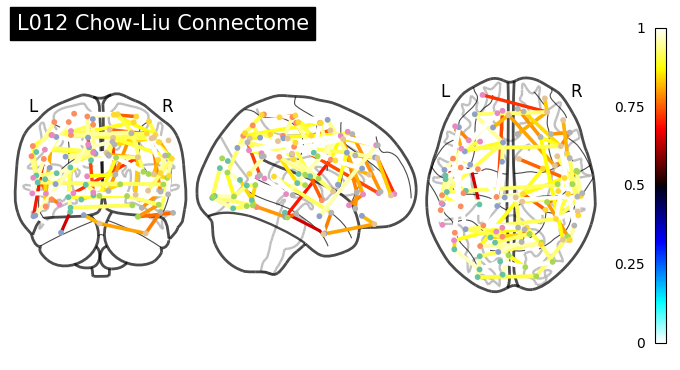

In [90]:
plot_connectome(mst_sub2, schaefer_coords, title='L012 Chow-Liu Connectome', edge_threshold="0%")

In [91]:
def draw_chow_liu_tree(G, root=0):
    """
    Visualize the Chow-Liu tree using a spring layout (no pygraphviz).
    """
    tree = nx.bfs_tree(G, source=root)
    pos = nx.spring_layout(tree, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, arrows=True, node_color="lightblue", 
            edge_color="black", node_size=1500, font_size=12)
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels)

    plt.title("Chow-Liu Tree (Spring Layout)")
    plt.axis("off")
    plt.show()

def hierarchy_pos(G, root=None, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Hierarchical layout for directed trees. Assigns space to subtrees to avoid squishing.
    """
    def _count_descendants(G, node):
        children = list(G.successors(node))
        if not children:
            return 1
        return sum(_count_descendants(G, child) for child in children)

    def _hierarchy_pos(G, node, left, right, vert_loc, pos):
        center = (left + right) / 2
        pos[node] = (center, vert_loc)
        children = list(G.successors(node))
        if children:
            total = sum(_count_descendants(G, child) for child in children)
            dx = (right - left) / total
            next_left = left
            for child in children:
                size = _count_descendants(G, child)
                next_right = next_left + dx * size
                pos = _hierarchy_pos(G, child, next_left, next_right, vert_loc - vert_gap, pos)
                next_left = next_right
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

def get_node_regions(tree):

    networks = []
    for node in tree.nodes:
        network = str(schaefer.labels[node]).split('_')[2]
        networks.append(network)
    return networks

def draw_hierarchical_tree(G, root=0, title = "Hierarchical Chow-Liu Tree"):
    """
    Draw Chow-Liu tree in a hierarchical top-down format.
    """
    # Ensure it's a directed tree rooted at `root`
    tree = nx.bfs_tree(G, source=root)

    pos = hierarchy_pos(tree, root)

    networks = get_node_regions(tree)

    # Create a color map based on the networks
    color_map = []
    network_names = ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']

    for node, network in zip(tree.nodes, networks):
        if network in network_names:
            color_map.append(colors[network_names.index(network)])
        else:
            color_map.append(0)
    
    # color_map = np.array(color_map)
    # color_map = color_map / max(color_map)
    
    plt.figure(figsize=(10, 6))
    nx.draw(tree, pos, with_labels=True, node_color=color_map, node_size=140,
            arrows=True, font_size=6, edge_color='gray')


    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    # nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size = 0)

    patches = [mpatches.Patch(color=color, label=network_name) for color, network_name in zip(colors, network_names)]
    plt.legend(handles=patches)

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

    return tree, pos, network_names, colors

In [92]:
# print schaefer parcels
print(schaefer.labels[63])

b'7Networks_RH_SomMot_6'


In [111]:
# load the saved matrices
mi_path_1 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L010/{atlas_subdir}/all_stories_100bins.csv'
mi_path_2 = f'{base_dir}/code/functional_connectivity/listen/output/mutual_information/L012/{atlas_subdir}/all_stories_100bins.csv'
sub1_mutual_info = pd.read_csv(mi_path_1).to_numpy()
sub2_mutual_info = pd.read_csv(mi_path_2).to_numpy()
G_sub1, mst_sub1 = get_chow_liu_tree(sub1_concat, mi_matrix=sub1_mutual_info)
G_sub2, mst_sub2 = get_chow_liu_tree(sub2_concat, mi_matrix=sub2_mutual_info)
G_sub1_corr, mst_sub1_corr = get_chow_liu_tree(sub1_concat, mi_matrix=sub1_cov)
G_sub2_corr, mst_sub2_corr = get_chow_liu_tree(sub2_concat, mi_matrix=sub2_cov)

In [167]:
G_sub1_ait, mst_sub1_ait = get_chow_liu_tree(story_timeseries['L010']['alternateithicatom'].T, mi_matrix=sub1_mutual_info_ait)
G_sub2_ait, mst_sub2_ait = get_chow_liu_tree(story_timeseries['L012']['alternateithicatom'].T, mi_matrix=sub2_mutual_info_ait)
G_sub1_ait_100, mst_sub1_ait_100 = get_chow_liu_tree(story_timeseries['L010']['alternateithicatom'].T, mi_matrix=sub1_mutual_info_ait_100)
G_sub2_ait_100, mst_sub2_ait_100 = get_chow_liu_tree(story_timeseries['L012']['alternateithicatom'].T, mi_matrix=sub2_mutual_info_ait_100)

In [190]:
story_graphs = {}
story_mst = {}
story_graphs['L010'] = {}
story_mst['L010'] = {}
story_graphs['L012'] = {}
story_mst['L012'] = {}

for story in stories['01']:
    story_graphs['L010'][story], story_mst['L010'][story] = get_chow_liu_tree(story_timeseries['L010'][story].T, mi_matrix=mutual_info_matrices[story]['L010'])
    story_graphs['L012'][story], story_mst['L012'][story] = get_chow_liu_tree(story_timeseries['L012'][story].T, mi_matrix=mutual_info_matrices[story]['L012'])

for story in stories['02']:
    session = '02'
    if session == '02' and story == 'wheretheressmoke': 
        story_name = 'wheretheressmoke_2'
    else: 
        story_name = story
    story_graphs['L010'][story_name], story_mst['L010'][story_name] = get_chow_liu_tree(story_timeseries['L010'][story].T, mi_matrix=mutual_info_matrices[story]['L010'])
    story_graphs['L012'][story_name], story_mst['L012'][story_name] = get_chow_liu_tree(story_timeseries['L012'][story].T, mi_matrix=mutual_info_matrices[story]['L012'])

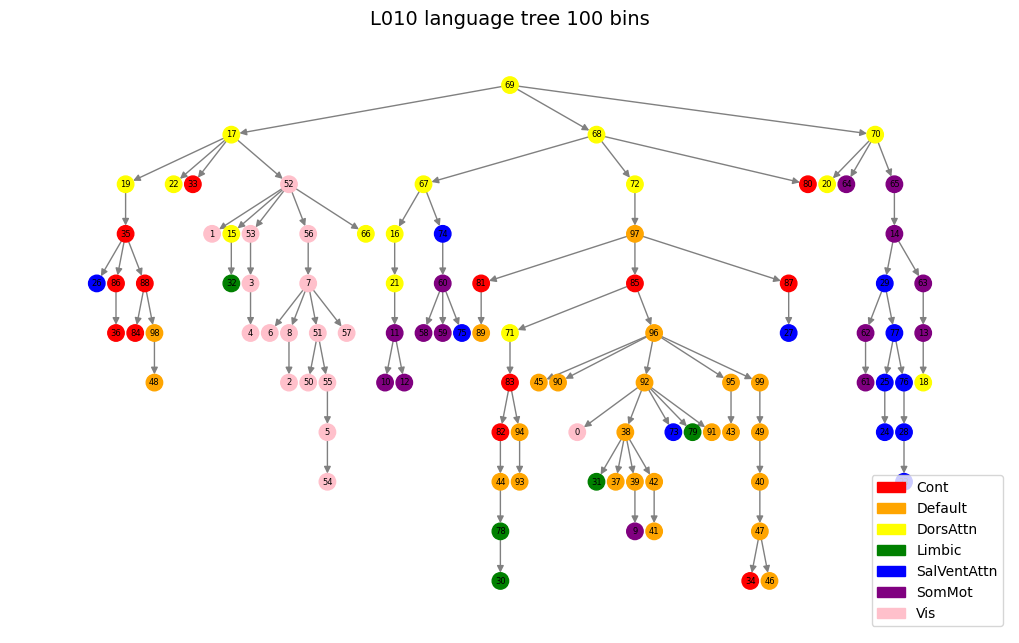

In [117]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub1, root=69, title="L010 language tree 100 bins")
# visual process in parallel with default to process the task
# vision guided process, default mentalizes internal processes not dependent on internal stimuli
# hierarchical process from lower level to higher level function
# external stimuli processing --> response
# left is processes relevant to external stimuli, right is more internal cross-modal processing

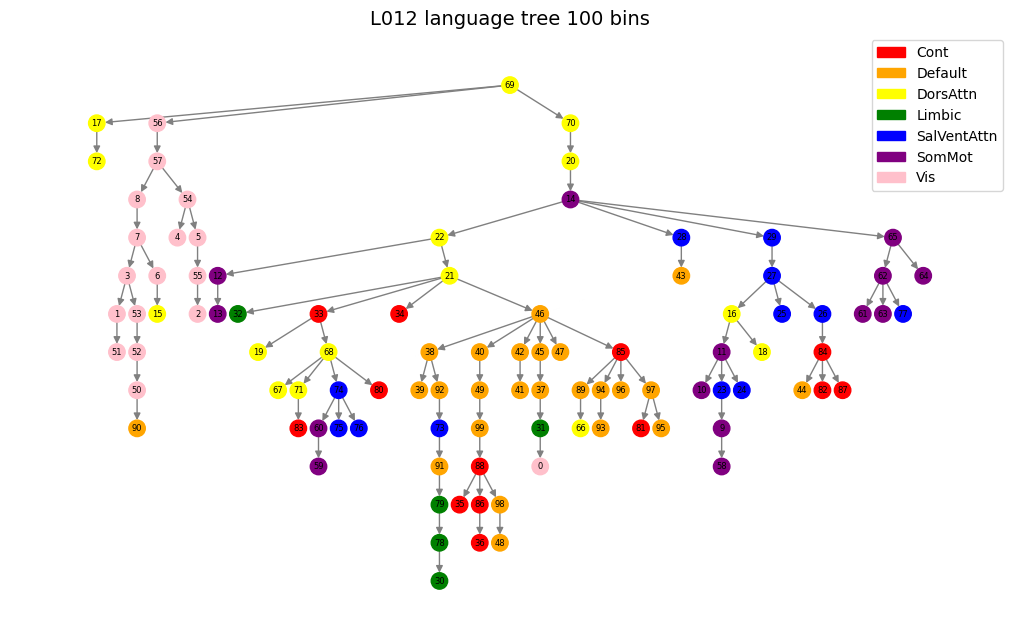

In [168]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub2, root=69, title="L012 language tree 100 bins")

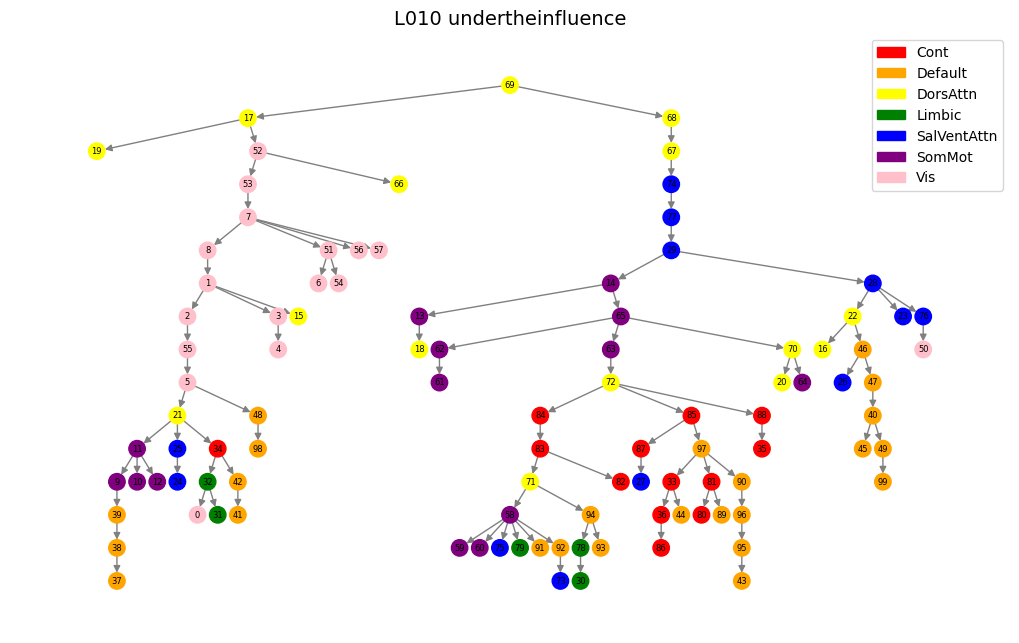

In [198]:
story = stories['02'][3]
tree, pos, network_names, colors = draw_hierarchical_tree(story_graphs['L010'][story], root=69, title=f"L010 {story}")

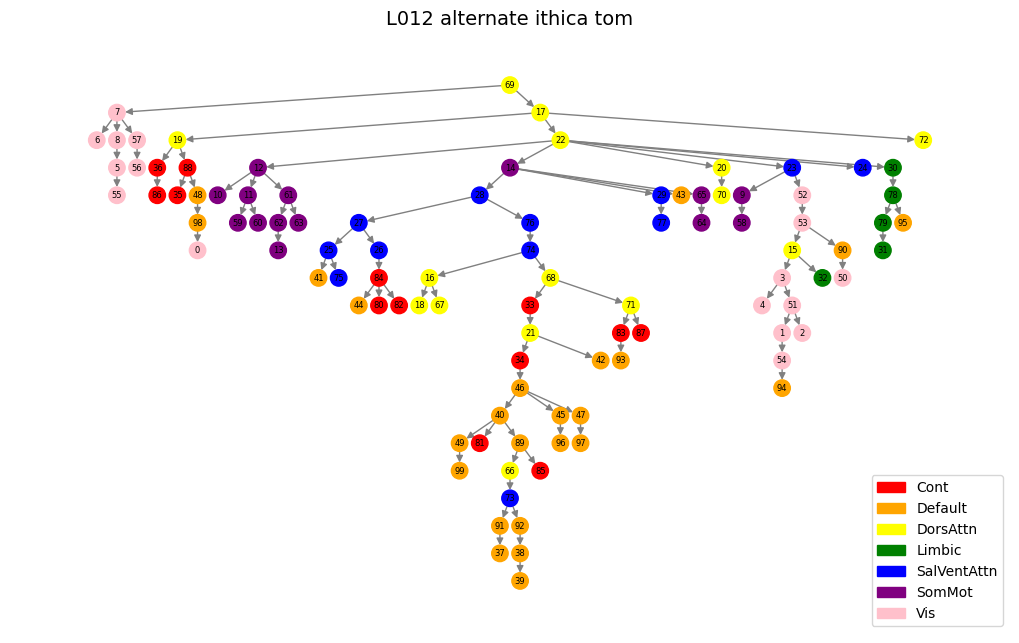

In [162]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub2_ait, root=69, title="L012 alternate ithica tom")

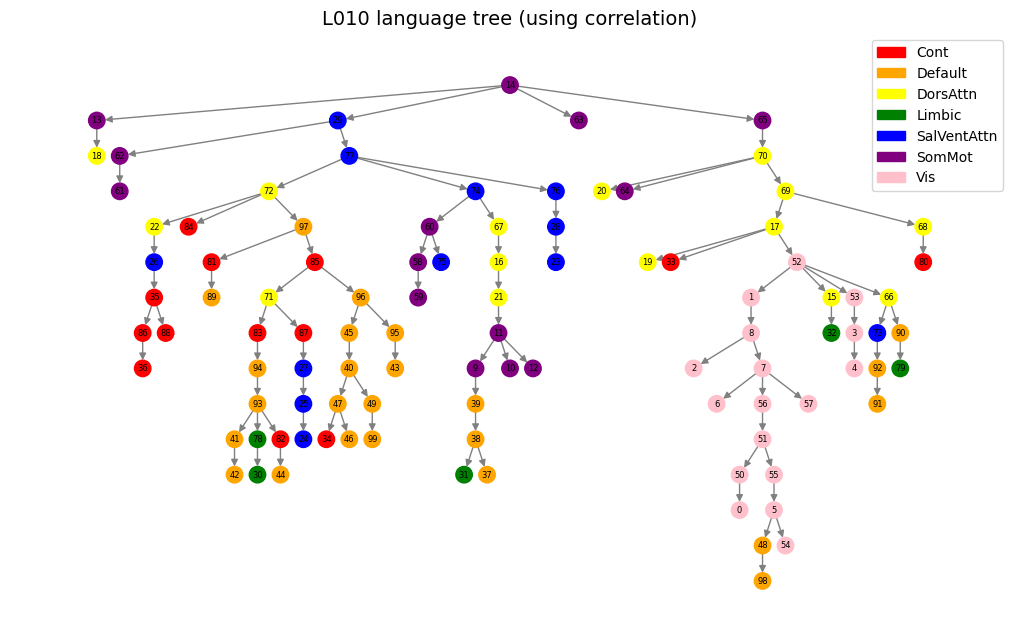

In [75]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub1_corr, root=14, title="L010 language tree (using correlation)")

In [117]:
def graph_fc(fc_matrix):

    # Create NetworkX graph for visualization or further use
    G = nx.Graph()
    n = fc_matrix.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            if fc_matrix[i, j] != 0:
                G.add_edge(i, j, weight=fc_matrix[i, j])
    
    return G

In [118]:
# load the saved matrices
sub1_corr = pd.read_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/connectome_corr/msc01/schaefer_100/motor.csv').to_numpy()
sub2_corr = pd.read_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/connectome_corr/msc03/schaefer_100/motor.csv').to_numpy()

In [125]:
G_corr_1 = graph_fc(sub1_corr)
G_corr_2 = graph_fc(sub2_corr)

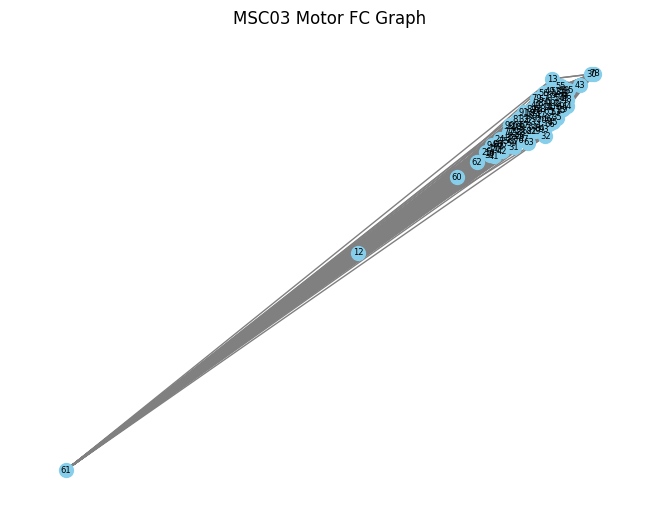

In [126]:
nx.draw(G_corr_2, with_labels=True, node_color='skyblue', node_size=100, font_size=6, edge_color='gray')
plt.title("MSC03 Motor FC Graph")
plt.show()

In [128]:
def plot_connectome_networks(cov_matrix, coords, title='connectome', edge_threshold="0%", legend=True, edge_vmin=0, edge_vmax=1):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """

    networks = []

    for region in schaefer.labels:
        network = str(region).split('_')[2]
        networks.append(network)
    
    network_names = ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']


    # Create a color map based on the networks
    color_map = []

    for network in networks:
        if network in network_names:
            color_map.append(colors[network_names.index(network)])
        else:
            color_map.append(0)
    
    # Plotting the connectome
    plotting.plot_connectome(
        cov_matrix,
        coords,
        title=title,
        edge_vmin = edge_vmin,
        edge_vmax = edge_vmax,
        edge_cmap='cold_hot',
        node_color=color_map,
        colorbar=True,
        edge_threshold=edge_threshold,  # Only plot edges above the 90th percentile
        node_size=50,
    )
    
    patches = [mpatches.Patch(color=color, label=network_name) for color, network_name in zip(colors, network_names)]
    if legend: 
        plt.legend(handles=patches, loc=(0,1), fontsize=8)
    
    plt.show()

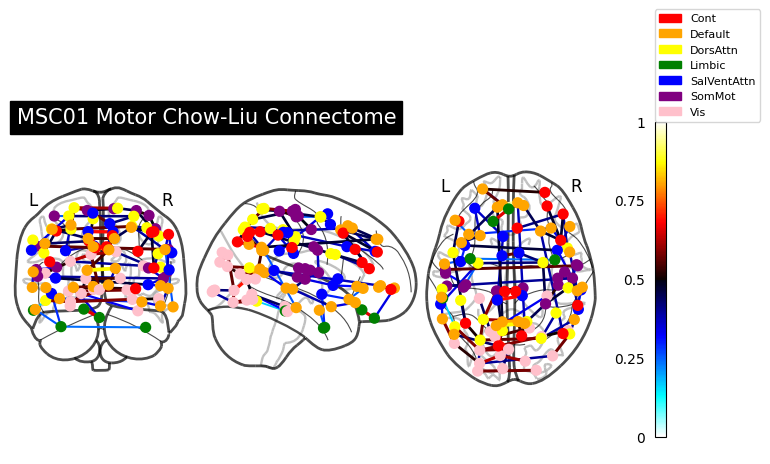

In [105]:
plot_connectome_networks(mst_sub1, schaefer_coords, title='MSC01 Motor Chow-Liu Connectome', edge_threshold="0%")

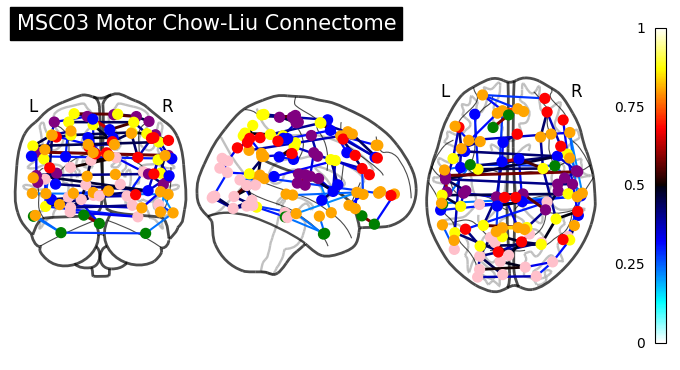

In [130]:
plot_connectome_networks(mst_sub2, schaefer_coords, title='MSC03 Motor Chow-Liu Connectome', legend=False, edge_threshold="0%")

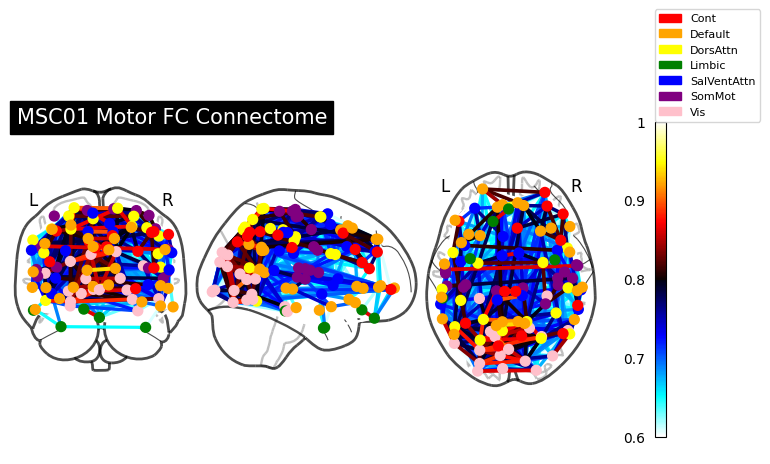

In [115]:
plot_connectome_networks(sub1_corr, schaefer_coords, title='MSC01 Motor FC Connectome', edge_vmin=0.6, edge_threshold="0%")

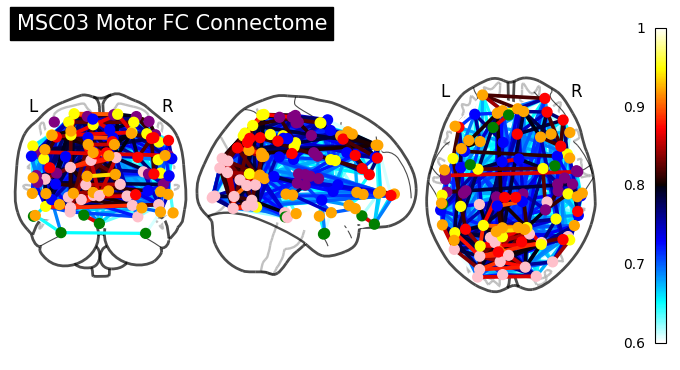

In [129]:
plot_connectome_networks(sub2_corr, schaefer_coords, title='MSC03 Motor FC Connectome', edge_vmin=0.6, legend=False, edge_threshold="0%")